In [12]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

df_train = pd.read_csv('./titanic/train.csv')

In [13]:
def impute(pclass, elem, pclass_dict): 
    """欠損値の補完"""
    if pd.isnull(elem):
        return pclass_dict[pclass]
    else:
        return elem

def impute_age(cols):
    """Age の欠損値を補完"""
    pclass=cols[1]
    age=cols[0]
    pclass_age = {1: 39, 2: 30, 3: 25}

    return impute(pclass, age, pclass_age)

def impute_fare(cols):
    """Fare の欠損値を補完"""
    pclass = cols[1]
    fare = cols[0]    
    pclass_fare = {1: 84.254687, 2: 20.662183, 3: 13.675550}

    return impute(pclass, fare, pclass_fare)

In [14]:
#for dataset in df_train:
# - Sex -
# 型変換(object → int)
df_train['Sex'] = df_train['Sex'].map({'male': 0, 'female': 1})

# - Age -
# 欠損値を客席クラスの平均で補完
df_train['Age'] = df_train[['Age', 'Pclass']].apply(impute_age, axis = 1)
# binning
df_train['CategoricalAge'] = pd.qcut(df_train['Age'], 4, labels=False)

# - Embarked -
# 欠損値を最頻値の S で埋める。
df_train.loc[df_train['Embarked'].isnull(), 'Embarked'] = 'S'
# 型変換(object → int)
df_train['Embarked'] = df_train['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})

# - Fare -
# 欠損値を客席クラスの平均で補完
df_train['Fare'] = df_train[['Fare', 'Pclass']].apply(impute_fare, axis = 1)
# binning
df_train['CategoricalFare'] = pd.qcut(df_train['Fare'], 4, labels=False)

# 新しい特徴量 FamilySize を作成
df_train['FamilySize'] = df_train['SibSp'] + df_train['Parch'] + 1

# 新しい特徴量 IsAlone を作成
df_train['IsAlone'] = 0
df_train.loc[df_train['FamilySize'] == 1, 'IsAlone'] = 1


In [21]:
df_train.drop(['PassengerId', 'Name',  'Age', 'SibSp', 'Parch', 'Fare', 'Cabin', 'Ticket'], axis=1, inplace=True)

KeyError: "['PassengerId' 'Name' 'Age' 'SibSp' 'Parch' 'Fare' 'Cabin' 'Ticket'] not found in axis"

In [55]:
df_train.keys()

Index(['Survived', 'Pclass', 'Sex', 'Embarked', 'CategoricalAge',
       'CategoricalFare', 'FamilySize', 'IsAlone'],
      dtype='object')

In [24]:
X_train = df_train.drop(['Survived'], axis=1)
y_train = df_train['Survived']

In [31]:
X_train.keys()

Index(['Pclass', 'Sex', 'Embarked', 'CategoricalAge', 'CategoricalFare',
       'FamilySize', 'IsAlone'],
      dtype='object')

In [32]:
import sklearn.preprocessing as preproc

In [42]:
# ペアワイズ交互作用特徴量を作成
X2_train = preproc.PolynomialFeatures(include_bias=False).fit_transform(X_train)

In [43]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

clfs = {'random_forest': RandomForestClassifier(random_state=0),
        'extra_trees': ExtraTreesClassifier(random_state=0),
        'ada_boost': AdaBoostClassifier(random_state=0),
        'gradient_boosting': GradientBoostingClassifier(random_state=0),
        'xgboost': XGBClassifier(random_state=0)
}

In [44]:
for k, clf in clfs.items():
    clf.fit(X2_train, y_train)

/Users/armeria/.pyenv/versions/anaconda3-5.3.0/envs/py36/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/armeria/.pyenv/versions/anaconda3-5.3.0/envs/py36/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [56]:
X2_train.shape # +28カラム？どういう基準だ→重複ありのコンビネーションだ

(891, 35)

In [57]:
X_train.shape

(891, 7)

In [58]:
X2_train[0]

array([3., 0., 0., 0., 0., 2., 0., 9., 0., 0., 0., 0., 6., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 4., 0.,
       0.])

In [62]:
X_train[:10]

,Pclass,Sex,Embarked,CategoricalAge,CategoricalFare,FamilySize,IsAlone
0,3,0,0,0,0,2,0
1,1,1,1,3,3,2,0
2,3,1,0,1,1,1,1
3,1,1,0,2,3,2,0
4,3,0,0,2,1,1,1
5,3,0,2,1,1,1,1
6,1,0,0,3,3,1,1
7,3,0,0,0,2,5,0
8,3,1,0,2,1,3,0
9,2,1,1,0,2,2,0


In [50]:
feature_dataframe = pd.DataFrame( {
                                   #'features': X2_train.columns,
                                   'RandomForest': clfs['random_forest'].feature_importances_,
                                   'ExtraTrees':  clfs['extra_trees'].feature_importances_,
                                   'AdaBoost': clfs['ada_boost'].feature_importances_,
                                   'GradiendBoostiong': clfs['gradient_boosting'].feature_importances_,
                                   'XGBoost': clfs['xgboost'].feature_importances_,
})

In [51]:
feature_dataframe

,RandomForest,ExtraTrees,AdaBoost,GradiendBoostiong,XGBoost
0,0.050325,0.047788,0.04,0.039330,0.153493
1,0.015538,0.179829,0.00,0.116664,0.464339
2,0.012953,0.006612,0.00,0.004050,0.030961
3,0.025009,0.021245,0.04,0.001255,0.007727
4,0.024429,0.024569,0.00,0.002608,0.012716
5,0.026468,0.017543,0.04,0.016735,0.014414
6,0.000729,0.016449,0.00,0.000003,0.000000
7,0.022918,0.085779,0.04,0.042995,0.000000
8,0.112913,0.057495,0.08,0.290448,0.023419
9,0.016734,0.007167,0.02,0.003857,0.005714


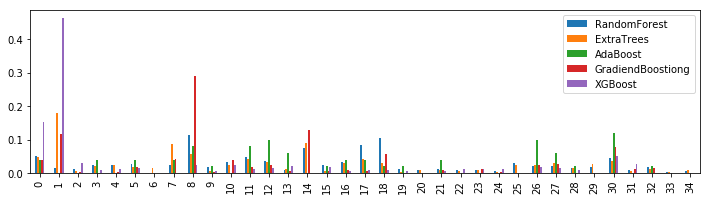

In [53]:
feature_dataframe.plot.bar(figsize=(12, 3))